## 1. General Statistics Difference
This notebook compares ripple power, MUA, and cell number engagement for fragmented and continuous replays

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import cupy as cp
import numpy as np
import datajoint as dj
import spyglass as nd
import pandas as pd
import matplotlib.pyplot as plt
import json
import multiprocessing

# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common import TaskEpoch
import spyglass.spikesorting.v0 as ss

from spyglass.spikesorting.v0 import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,
                                   CuratedSpikeSortingSelection,CuratedSpikeSorting,Curation)
from spyglass.spikesorting.v0.curation_figurl import CurationFigurl,CurationFigurlSelection
from spyglass.spikesorting.v0.spikesorting_curation import MetricParameters,MetricSelection,QualityMetrics
from spyglass.spikesorting.v0.spikesorting_curation import WaveformParameters,WaveformSelection,Waveforms
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection,IntervalLinearizedPosition

from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from pprint import pprint
from spyglass.shijiegu.ripple_detection import removeDataBeforeTrial1
from spyglass.shijiegu.helpers import interpolate_to_new_time
from spyglass.shijiegu.placefield import place_field,placefield_to_peak1dloc
from spyglass.shijiegu.Analysis_SGU import DecodeResultsLinear
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=ResourceWarning)
warnings.filterwarnings('ignore')

[2024-08-22 14:45:28,357][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2024-08-22 14:45:28,463][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [5]:
from spyglass.shijiegu.helpers import interval_union
from spyglass.shijiegu.Analysis_SGU import TrialChoice,RippleTimes,EpochPos,ExtendedRippleTimes,RippleTimesWithDecode
from spyglass.shijiegu.load import load_run_sessions
from spyglass.shijiegu.singleUnit import do_mountainSort,electrode_unit,RippleTime2FiringRate,findWaveForms,RippleTime2Index

In [6]:
outputFolder='/cumulus/shijie/recording_pilot/eliot/FragmentedReplay/'

In [7]:
nwb_copy_file_name = "eliot20221024_.nwb" #"eliot20221022_.nwb"

In [8]:
run_session_ids, run_session_names, pos_session_names = load_run_sessions(nwb_copy_file_name)

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
eliot20221024_ 1         01_Seq2Sleep1  pos 0 valid ti
eliot20221024_ 2         02_Seq2Session pos 1 valid ti
eliot20221024_ 3         03_Seq2Sleep2  pos 2 valid ti
eliot20221024_ 4         04_Seq2Session pos 3 valid ti
eliot20221024_ 5         05_Seq2Sleep3  pos 4 valid ti
eliot20221024_ 6         06_Seq2Session pos 5 valid ti
eliot20221024_ 7         07_Seq2Sleep4  pos 6 valid ti
eliot20221024_ 8         08_Seq2Session pos 7 valid ti
eliot20221024_ 9         09_Seq2Sleep5  pos 8 valid ti
eliot20221024_ 10        10_Seq2Session pos 9 valid ti
eliot20221024_ 11        11_Seq2Sleep6  pos 10 valid t
 (Total: 11)



In [9]:
epoch_num = 4 #3
session_name = run_session_names[epoch_num]
pos_name = pos_session_names[epoch_num]
print(session_name)
print(pos_name)

10_Seq2Session6
pos 9 valid times


### 1.load ripple data

In [10]:
from spyglass.shijiegu.ripple_detection import (loadRippleLFP_OneChannelPerElectrode,
                        get_zscored_Kay_ripple_consensus_trace,
                        removeArtifactTime)
from spyglass.shijiegu.load import load_position,load_zscored_ripple_consensus,load_maze_spike

In [14]:
consensus, consensus_t = load_zscored_ripple_consensus(nwb_copy_file_name, session_name, pos_name)

Using LFP from these eletrodes: 
[ 0  2  4  5 13 14 16 17 20 26 27 28 29 30 31]


The shape of LFP input is (1838649, 15)


### 2. Find ripple power difference

In [15]:
ripple_times = pd.DataFrame((RippleTimesWithDecode & 
                             {'nwb_file_name': nwb_copy_file_name, 'interval_list_name': session_name}).fetch1('ripple_times'))

In [16]:
def find_SWR_zscore(ripple_times,consensus,consensus_t,stat = 'max',cont = True):
    SWR_median = []
    for i in ripple_times.index:
        if cont:
            intvls = ripple_times.loc[i].cont_intvl
        else:
            intvls = ripple_times.loc[i].frag_intvl
        for intvl in intvls:
            ind = np.logical_and(consensus_t >= intvl[0],consensus_t <= intvl[1])
            consensus_subset = consensus[ind]
            if stat == 'max':
                SWR_median.append(np.nanmax(consensus_subset))
            elif stat == 'median':
                SWR_median.append(np.nanmedian(consensus_subset))
    return SWR_median
    

In [17]:
SWR_median_cont = {}
SWR_median_frag = {}
for stats in ["max", "median"]:
    SWR_median_cont[stats] = find_SWR_zscore(ripple_times,consensus,consensus_t,stat = stats, cont = True)
    SWR_median_frag[stats] = find_SWR_zscore(ripple_times,consensus,consensus_t,stat = stats, cont = False)

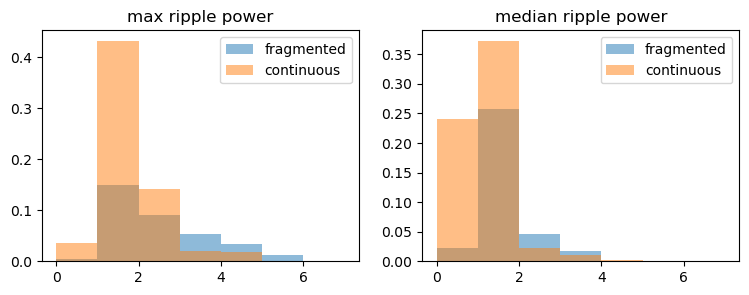

In [18]:
fig, axes = plt.subplots(1, 2, figsize = (9,3))
axes_ind = 0
for stats in ["max", "median"]:
    data1 = SWR_median_frag[stats]
    data2 = SWR_median_cont[stats]
    axes[axes_ind].hist(data1,bins = np.arange(8),alpha = 0.5,
         weights = np.ones(len(data1))/(len(data1)+len(data2)),label = 'fragmented')

    
    axes[axes_ind].hist(data2,bins = np.arange(8),alpha = 0.5,
         weights = np.ones(len(data2))/(len(data1)+len(data2)),label = 'continuous')
    axes[axes_ind].set_title(stats+' ripple power',fontsize = 12)
    axes[axes_ind].legend()
    axes_ind += 1
    

In [21]:
#

#### Given a high power ripple, the percentage of fragmented vs cont

In [19]:
stats = "max"
data1 = np.array(SWR_median_frag[stats])
data2 = np.array(SWR_median_cont[stats])

perc = len(data1)/(len(data2)+len(data1))
print(f'Overall, {round(perc*100,1)} percentage of intervals in SWR events are fragmented.')

frag_num = len(data1[data1 >= 4])
cont_num = len(data2[data2 >= 4])
perc = frag_num/(frag_num+cont_num)
print(f'Specifically, among the intervals that contain ripple power >= 4, {perc * 100} percentage of them are fragmented.')

frag_num = len(data1[data1 >= 3])
cont_num = len(data2[data2 >= 3])
perc = frag_num/(frag_num+cont_num)
print(f'Among the intervals that contain ripple power >= 3, {round(perc*100,1)} percentage of them are fragmented.')

frag_num = len(data1[data1 >= 2])
cont_num = len(data2[data2 >= 2])
perc = frag_num/(frag_num+cont_num)
print(f'Among the intervals that contain ripple power >= 2, {round(perc*100,1)} percentage of them are fragmented.')

Overall, 34.6 percentage of intervals in SWR events are fragmented.
Specifically, among the intervals that contain ripple power >= 4, 72.0 percentage of them are fragmented.
Among the intervals that contain ripple power >= 3, 72.2 percentage of them are fragmented.
Among the intervals that contain ripple power >= 2, 51.4 percentage of them are fragmented.


### 3. find MUA difference

In [80]:
# load MUA
neural_data,neural_ts,mua_time,mua,channel_IDs = load_maze_spike(nwb_copy_file_name,
                                                                 session_name)

In [86]:
from scipy.stats import zscore
mua_zscored = zscore(mua, nan_policy = 'omit')

In [88]:
MUA_median_cont = {}
MUA_median_frag = {}
for stats in ["max", "median"]:
    MUA_median_cont[stats] = find_SWR_zscore(ripple_times,mua_zscored,mua_time,stat = stats, cont = True)
    MUA_median_frag[stats] = find_SWR_zscore(ripple_times,mua_zscored,mua_time,stat = stats, cont = False)

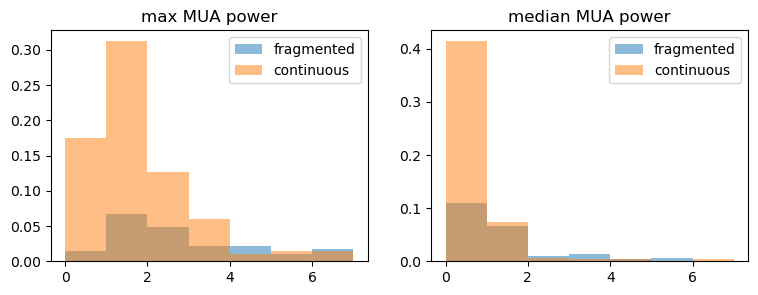

In [223]:
fig, axes = plt.subplots(1, 2, figsize = (9,3))
axes_ind = 0
for stats in ["max", "median"]:
    data1 = MUA_median_frag[stats]
    axes[axes_ind].hist(data1,bins = np.arange(8),alpha = 0.5,
         weights = np.ones(len(data1))/(len(data1)+len(data2)),label = 'fragmented')

    data2 = MUA_median_cont[stats]
    axes[axes_ind].hist(data2,bins = np.arange(8),alpha = 0.5,
         weights = np.ones(len(data2))/(len(data1)+len(data2)),label = 'continuous')
    axes[axes_ind].set_title(stats+' MUA power',fontsize = 12)
    axes[axes_ind].legend()
    axes_ind += 1
    

### 4. the number of participating cells

In [227]:
# load unit data
key = {"nwb_file_name": nwb_copy_file_name,
       "sorter":"mountainsort4",
       "sort_interval_name":session_name}
sort_group_ids = np.unique((QualityMetrics & key).fetch("sort_group_id"))

sort_group_ids_with_good_cell = []       
electrodes_units = {}
for sort_group_id in sort_group_ids:
    nwb_units = electrode_unit(nwb_copy_file_name,session_name,sort_group_id)
    if len(nwb_units)==0:
        continue
    electrodes_units[sort_group_id] = nwb_units
    sort_group_ids_with_good_cell.append(sort_group_id)

In [228]:
cell_list = []
for e in sort_group_ids_with_good_cell:
    for u in electrodes_units[e].index:
        cell_list.append((e, u))

In [229]:
def find_spikes(electrodes_units,cell_list,axis,DELTA_T):
    firing_matrix = np.zeros((len(axis)-1,len(cell_list)))
    for i in range(len(cell_list)):
        (e, u) = cell_list[i]
        firing_matrix[:,i], _ = np.histogram(electrodes_units[e].loc[u].spike_times,axis)
    
    return firing_matrix

In [240]:
def find_number_of_cells(ripple_times, electrodes_units, cont = True, DELTA_T = 0.04):
    num_all = []
    
    for i in ripple_times.index:

        if cont:
            intvls = ripple_times.loc[i].cont_intvl
        else:
            intvls = ripple_times.loc[i].frag_intvl
    
        for intvl in intvls:
            axis = np.array([intvl[0], intvl[1]])
            firing_matrix = find_spikes(electrodes_units,cell_list,axis,DELTA_T)
            num = np.sum(np.sum(firing_matrix, axis = 0)>0)/len(cell_list)
            num_all.append(num)
    
    return num_all

In [241]:
num_frag = find_number_of_cells(ripple_times, electrodes_units, cont = False)
num_cont = find_number_of_cells(ripple_times, electrodes_units, cont =  True)

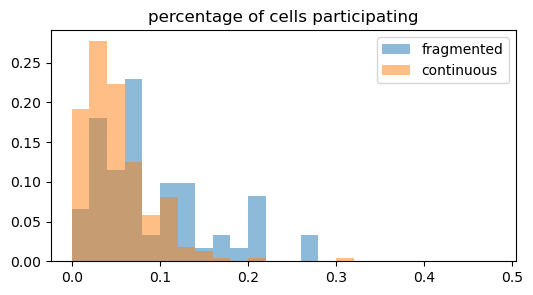

In [248]:
fig, axes = plt.subplots(1, 1, figsize = (6,3))

data1 = num_frag
axes.hist(data1,bins = np.arange(0,0.5,0.02),alpha = 0.5,
        weights = np.ones(len(data1))/(len(data1)),label = 'fragmented')

data2 = num_cont
axes.hist(data2,bins = np.arange(0,0.5,0.02),alpha = 0.5,
        weights = np.ones(len(data2))/(len(data2)),label = 'continuous')
axes.set_title('percentage of cells participating',fontsize = 12)
axes.legend()


### End here

### 1. >20 ms long Fragment moment triggered continuous

In [ ]:
DELTA_T = 1
RESOLUTION = 0.005

In [262]:
# put all cont intvl into one array
intvl_cont = []
for i in ripple_times.index:
    intvls = ripple_times.loc[i].cont_intvl
    if len(intvls)>0:
        intvl_cont.append(intvls)
intvl_cont_all = np.concatenate(intvl_cont)

# put all frag intvl into one array
intvl_frag = []
for i in ripple_times.index:
    intvls = ripple_times.loc[i].frag_intvl
    if len(intvls)>0:
        intvl_frag.append(intvls)
intvl_frag_all = np.concatenate(intvl_frag)

In [355]:
cont_onset_all = [] #this is the list of onset
cont_all = [] #this is the list that will keep all cont time

for i in ripple_times.index:
    intvls = ripple_times.loc[i].frag_intvl
    for intvl in intvls:
        if (intvl[1] - intvl[0]) < 0.02:
            continue
        (t0,t1) = (intvl[0] - DELTA_T, intvl[0] + DELTA_T)

        # find all cont ripple intervals that are within t0-t1
        ripple_ind_start = np.argwhere(intvl_cont_all[:,1] >= t0).ravel()[0]
        ripple_ind_end = np.argwhere(intvl_cont_all[:,0] <= t1).ravel()[-1]
        
        intvl_cont_ = intvl_cont_all[np.arange(ripple_ind_start,ripple_ind_end+1)]
        for intvl_cont in intvl_cont_:
            cont_onset_all.append(intvl_cont[0]-intvl[0])
            cont_all.append(np.arange(intvl_cont[0],intvl_cont[1],RESOLUTION) - intvl[0]) #center around the fragmented

In [356]:
number_of_cont = len(cont_all)
cont_all = np.concatenate(cont_all)

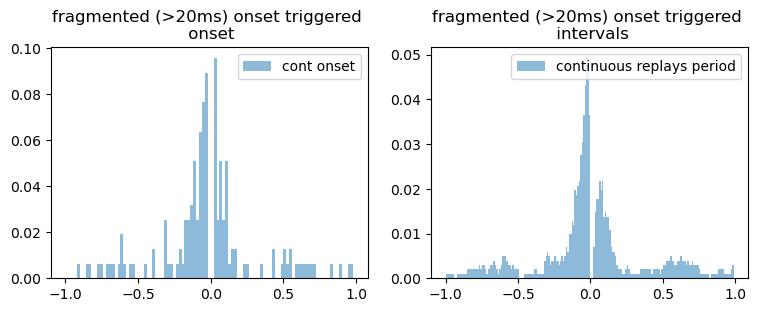

In [361]:
fig, axes = plt.subplots(1, 2, figsize = (9,3))

RESOLUTION = 0.02
axes[0].hist(cont_onset_all,np.arange(0,2*DELTA_T,RESOLUTION) - DELTA_T,alpha = 0.5,
        weights = np.ones(number_of_cont)/(number_of_cont),label = 'cont onset')

axes[0].set_title('fragmented (>20ms) onset triggered \n onset',fontsize = 12)
axes[0].legend()

RESOLUTION = 0.01
axes[1].hist(cont_all,np.arange(0,2*DELTA_T,RESOLUTION) - DELTA_T,alpha = 0.5,
        weights = np.ones(len(cont_all))/(len(cont_all)),label = 'continuous replays period')

axes[1].set_title('fragmented (>20ms) onset triggered \n intervals',fontsize = 12)
axes[1].legend()

### 5(2) >20 ms long Fragment moment triggered fragmented

In [350]:
frag_onset_all = [] #this is the list of onset
frag_all = [] #this is the list that will keep all cont time

for i in ripple_times.index:
    intvls = ripple_times.loc[i].frag_intvl
    for intvl in intvls:
        if (intvl[1] - intvl[0]) < 0.02:
            continue
        (t0,t1) = (intvl[0] - DELTA_T, intvl[0] + DELTA_T)

        # find all cont ripple intervals that are within t0-t1
        ripple_ind_start = np.argwhere(intvl_frag_all[:,1] >= t0).ravel()[0]
        ripple_ind_end = np.argwhere(intvl_frag_all[:,0] <= t1).ravel()[-1]
        
        intvl_frag_ = intvl_frag_all[np.arange(ripple_ind_start,ripple_ind_end+1)]
        for intvl_frag in intvl_frag_:
            if intvl_frag[0] == intvl[0]:
                continue
            frag_onset_all.append(intvl_frag[0]-intvl[0])
            frag_all.append(np.arange(intvl_frag[0],intvl_frag[1],RESOLUTION) - intvl[0]) #center around the fragmented

In [352]:
number_of_frag = len(frag_all)
frag_all = np.concatenate(frag_all)

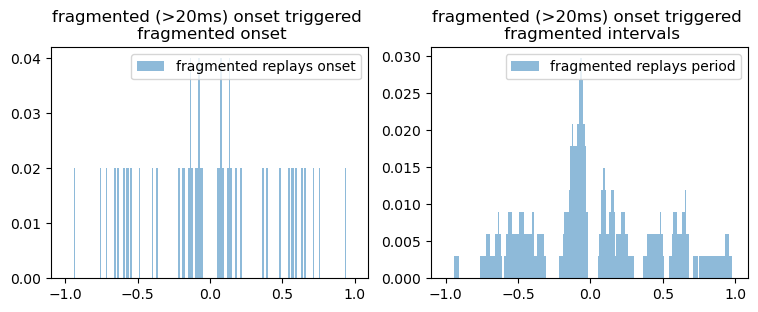

In [353]:
fig, axes = plt.subplots(1, 2, figsize = (9,3))

RESOLUTION = 0.01
axes[0].hist(frag_onset_all,np.arange(0,2*DELTA_T,RESOLUTION) - DELTA_T,alpha = 0.5,
        weights = np.ones(number_of_frag)/(number_of_frag),label = 'fragmented replays onset')

axes[0].set_title('fragmented (>20ms) onset triggered \n fragmented onset',fontsize = 12)
axes[0].legend()

RESOLUTION = 0.01
axes[1].hist(frag_all,np.arange(0,2*DELTA_T,RESOLUTION) - DELTA_T,alpha = 0.5,
        weights = np.ones(len(frag_all))/(len(frag_all)),label = 'fragmented replays period')

axes[1].set_title('fragmented (>20ms) onset triggered \n fragmented intervals',fontsize = 12)
axes[1].legend()

### 6. Cross correlation of sorted units spiking: to see if fragmented replays are more synchronized

In [585]:
# load unit data
key = {"nwb_file_name": nwb_copy_file_name,
       "sorter":"mountainsort4",
       "sort_interval_name":session_name}
sort_group_ids = np.unique((QualityMetrics & key).fetch("sort_group_id"))

sort_group_ids_with_good_cell = []       
electrodes_units = {}
for sort_group_id in sort_group_ids:
    nwb_units = electrode_unit(nwb_copy_file_name,session_name,sort_group_id)
    if len(nwb_units)==0:
        continue
    electrodes_units[sort_group_id] = nwb_units
    sort_group_ids_with_good_cell.append(sort_group_id)

In [586]:
cell_list = []
for e in sort_group_ids_with_good_cell:
    for u in electrodes_units[e].index:
        cell_list.append((e, u))

In [596]:
def find_spikes(electrodes_units,cell_list,axis,DELTA_T):
    firing_matrix = np.zeros((len(axis)-1,len(cell_list)))
    for i in range(len(cell_list)):
        (e, u) = cell_list[i]
        firing_matrix[:,i], _ = np.histogram(electrodes_units[e].loc[u].spike_times,axis)
    firing_matrix = firing_matrix / DELTA_T
    #firing_correlation = np.corrcoef(firing_matrix.T)
    #firing_correlation = firing_correlation[np.triu_indices(firing_matrix.shape[1],1)]
    #firing_correlation = firing_correlation[~np.isnan(firing_correlation)]
    
    return firing_matrix#firing_correlation

In [775]:
from scipy import signal
from scipy.linalg import norm

def xcorr(firing_matrix):
    xcorr_matrix = []
    pairs = []
    cell_num = np.shape(firing_matrix)[1]
    lag = signal.correlation_lags(firing_matrix.shape[0], firing_matrix.shape[0], mode='full')
    for i in range(cell_num):
        for j in range(i+1,cell_num):
            x = firing_matrix[:,i]
            y = firing_matrix[:,j]
            x = (x-np.mean(x))/norm(x)
            y = (y-np.mean(y))/norm(y)
            corr = signal.correlate(x, y, mode='full')
            xcorr_matrix.append(corr)
            pairs.append((i,j))
    xcorr_matrix = np.array(xcorr_matrix)
    # xcorr_matrix is number of pairs x time lag

    non_zeros_rows = np.argwhere(np.sum(xcorr_matrix>0,axis=1) > 0).ravel()
    pairs = np.array(pairs)[non_zeros_rows]
    xcorr_matrix = xcorr_matrix[non_zeros_rows,:].T

    # for output, we make xcorr_matrix into shape time lag x pairs, so it matches that of firing_matrix

    return xcorr_matrix,pairs,lag

In [777]:
def find_max_length(ripple_times,cont,DELTA_T):
    length_max = 0
    for i in ripple_times.index:
        if cont:
            intvls = ripple_times.loc[i].cont_intvl
        else:
            intvls = ripple_times.loc[i].frag_intvl
        
        for intvl in intvls:
            axis1 = np.arange(intvl[0], intvl[1], DELTA_T)
            
            if len(axis1) > length_max:
                length_max = len(axis1)
    return length_max-1

In [879]:
def find_firing_cross_correlation(ripple_times, electrodes_units, cont = True, DELTA_T = 0.04):
    length_max = find_max_length(ripple_times,cont,DELTA_T)
    lag = signal.correlation_lags(length_max, length_max, mode='full')
    
    length_max_plot = np.ceil(0.2/DELTA_T)
    lag_plot = signal.correlation_lags(length_max_plot, length_max_plot, mode='full')
    
    firing_correlation_all = []
    pairs_all = []
    
    for i in ripple_times.index:

        if cont:
            intvls = ripple_times.loc[i].cont_intvl
        else:
            intvls = ripple_times.loc[i].frag_intvl
    
        for intvl in intvls:
            axis1 = np.arange(intvl[0], intvl[1], DELTA_T)
            firing_matrix = find_spikes(electrodes_units,cell_list,axis1,DELTA_T)
            xcorr_matrix_,pairs,lag_ = xcorr(firing_matrix)

            # match shape
            ind1 = int(np.argwhere(lag == lag_[0]).ravel())
            ind2 = int(np.argwhere(lag == lag_[-1]).ravel())
            xcorr_matrix = np.zeros((len(lag),xcorr_matrix_.shape[1]))
            xcorr_matrix[ind1:ind2+1,:] = xcorr_matrix_
            firing_correlation_all.append(xcorr_matrix)
            pairs_all.append(pairs)
            
            #axis2 = np.concatenate((np.array([intvl[0]]),np.arange(intvl[0] + DELTA_T/2, intvl[1], DELTA_T)))
            #for axis in [axis1, axis2]:
            #     firing_matrix = find_spikes(electrodes_units,cell_list,axis,DELTA_T)
            #    firing_correlation_all.append(firing_correlation)
    firing_correlation_all = np.concatenate(firing_correlation_all,axis=1)
    if length_max_plot < length_max:
        ind1 = int(np.argwhere(lag == lag_plot[0]).ravel())
        ind2 = int(np.argwhere(lag == lag_plot[-1]).ravel())
    firing_correlation_all = firing_correlation_all[ind1:ind2+1,:]
    
    return firing_correlation_all,np.concatenate(pairs_all),lag[ind1:ind2+1]

In [836]:
from spyglass.shijiegu.singleUnit import do_mountainSort,electrode_unit,RippleTime2FiringRate

(firing_rate_by_ripple_F,firing_rate_F) = ({},{})
(firing_rate_by_ripple_C,firing_rate_C) = ({},{})
sort_group_ids_with_good_cell = []              
for sort_group_id in sort_group_ids:
    nwb_units = electrode_unit(nwb_copy_file_name,session_name,sort_group_id)
    if len(nwb_units)==0:
        continue
    sort_group_ids_with_good_cell.append(sort_group_id)
    (firing_rate_by_ripple_F[sort_group_id],
         firing_rate_F[sort_group_id]) = RippleTime2FiringRate(nwb_units,ripple_times,nwb_units.index,fragFlag = True)
    (firing_rate_by_ripple_C[sort_group_id],
         firing_rate_C[sort_group_id]) = RippleTime2FiringRate(nwb_units,ripple_times,nwb_units.index,fragFlag = False)
    
RATIO_FRAG = 1.5
RATIO_CONT = 0.5
cells_cont = []
cells_frag = []

for e in sort_group_ids_with_good_cell:
    for u in list(firing_rate_F[e].keys()):

        (rate_F, count_F, _) = firing_rate_F[e][u]
        print('electrode '+ str(e) + ' unit ' + str(u))
        print('during fragmented replay: ',rate_F, count_F)
    
        (rate_C, count_C, _) = firing_rate_C[e][u]
        print('during cont replay: ',rate_C, count_C)
        if count_C == 0 and count_F > 2:
            cells_frag.append((e,u))
            continue
    
        if count_C > 0 and count_F/count_C > RATIO_FRAG:
            cells_frag.append((e,u))
        elif count_C > 0 and count_F/count_C < RATIO_CONT:
            cells_cont.append((e,u))

electrode 0 unit 3
during fragmented replay:  7.304430676138095 31.0
during cont replay:  3.709264109928835 84.0
electrode 0 unit 4
during fragmented replay:  0.23562679600445469 1.0
during cont replay:  0.04415790607058137 1.0
electrode 0 unit 6
during fragmented replay:  2.8275215520534562 12.0
during cont replay:  1.9871057731761617 45.0
electrode 0 unit 7
during fragmented replay:  3.5344019400668203 15.0
during cont replay:  0.7506844031998833 17.0
electrode 0 unit 8
during fragmented replay:  1.1781339800222734 5.0
during cont replay:  0.1324737182117441 3.0
electrode 2 unit 3
during fragmented replay:  2.356267960044547 10.0
during cont replay:  1.1481055578351156 26.0
electrode 5 unit 2
during fragmented replay:  0.0 0.0
during cont replay:  0.9273160274822088 21.0
electrode 5 unit 5
during fragmented replay:  2.120641164040092 9.0
during cont replay:  0.30910534249406957 7.0
electrode 5 unit 6
during fragmented replay:  0.23562679600445469 1.0
during cont replay:  0.0 0.0
elec

In [860]:
def mark_frag_colors(cell_pairs_cont,cells_cont,cells_frag):
    colors = np.zeros((len(cell_pairs_cont),2),dtype='<U2')
    for cell_pair_ind in range(len(cell_pairs_cont)):
        cell_pair = cell_pairs_cont[cell_pair_ind]
        cell1= cell_pair[0]
        cell2= cell_pair[1]
        colors[cell_pair_ind,0] = 'k'
        colors[cell_pair_ind,1] = 'k'
        if len(set([cell1]).intersection(set(cells_cont))) > 0:
            colors[cell_pair_ind,0] = 'C1'
        elif len(set([cell1]).intersection(set(cells_frag))) > 0:
            colors[cell_pair_ind,0] = 'C0'
    
        if len(set([cell2]).intersection(set(cells_cont))) > 0:
            colors[cell_pair_ind,1] = 'C1'
        elif len(set([cell2]).intersection(set(cells_frag))) > 0:
            colors[cell_pair_ind,1] = 'C0'
    return colors
    

In [880]:
firing_corr_cont = {}
firing_corr_frag = {}
pairs_cont = {}
pairs_frag = {}

DELTA_Ts = [0.004] #[0.002, 0.004, 0.006, 0.01, 0.02, 0.03]
for DELTA_T in DELTA_Ts:
    firing_corr_cont[DELTA_T], pairs_cont[DELTA_T],lag_cont = find_firing_cross_correlation(ripple_times, electrodes_units, cont = True, DELTA_T = DELTA_T)
    firing_corr_frag[DELTA_T], pairs_frag[DELTA_T],lag_frag = find_firing_cross_correlation(ripple_times, electrodes_units, cont = False, DELTA_T = DELTA_T)

In [862]:
# make indices into cell identities
cell_pairs_cont = [[cell_list[p[0]],cell_list[p[1]]] for p in pairs_cont[DELTA_T]]
color_cont = mark_frag_colors(cell_pairs_cont,cells_cont,cells_frag)

cell_pairs_frag = [[cell_list[p[0]],cell_list[p[1]]] for p in pairs_frag[DELTA_T]]
color_frag = mark_frag_colors(cell_pairs_frag,cells_cont,cells_frag)

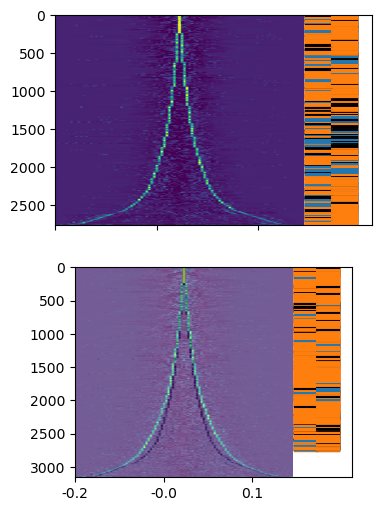

In [888]:
fig, axes = plt.subplots(2, 1, figsize = (12,6),sharex = True)
aspect = 0.03

data_matrix = firing_corr_cont[0.004].T
vmax = np.nanquantile(data_matrix,0.99)
vmin = np.nanquantile(data_matrix,0.1)

data_matrix = firing_corr_frag[0.004].T

center_ind = int(np.argwhere(lag_frag == 0).ravel())
row_order = np.argsort(np.abs(np.argmax(data_matrix,axis = 1)-center_ind))
row_num = data_matrix.shape[0]
axes[0].imshow(data_matrix[row_order,:],aspect = aspect,vmax = vmax,
          vmin = vmin,extent = [lag_frag[0],lag_frag[-1],row_num,0])

for r in row_order:
    axes[0].plot([50,60],[r,r],color = color_frag[r,0])
    axes[0].plot([60,70],[r,r],color = color_frag[r,1])



data_matrix = firing_corr_cont[0.004].T
row_num = data_matrix.shape[0]
center_ind = int(np.argwhere(lag_cont == 0).ravel())
row_order = np.argsort(np.abs(np.argmax(data_matrix,axis = 1)-center_ind))
axes[1].imshow(data_matrix[row_order,:],aspect = aspect,vmax = vmax,
          vmin = vmin,extent = [lag_cont[0],lag_cont[-1],row_num,0])

"""overlay"""
data_matrix = firing_corr_frag[0.004].T
center_ind = int(np.argwhere(lag_frag == 0).ravel())
row_order = np.argsort(np.abs(np.argmax(data_matrix,axis = 1)-center_ind))
#row_num = data_matrix.shape[0]
axes[1].imshow(data_matrix[row_order,:],aspect = aspect,vmax = vmax,alpha =0.3,
          vmin = vmin,extent = [lag_frag[0],lag_frag[-1],row_num,0],cmap = 'bone_r')

for r in row_order:
    axes[1].plot([50,60],[r,r],color = color_cont[r,0])
    axes[1].plot([60,70],[r,r],color = color_cont[r,1])

axes[1].set_xticks(lag_cont[::40]);
axes[1].set_xticklabels(np.round(lag_cont[::40]*DELTA_T,1));

In [925]:
frag_ind = np.argwhere(np.sum(color_frag == ['C0', 'C1'],axis = 1) == 2).ravel()
cont_ind = np.argwhere(np.sum(color_frag == ['C1', 'C1'],axis = 1) == 2).ravel()
order_partial = np.concatenate((frag_ind,cont_ind)).ravel()
row_order = np.concatenate((order_partial,np.setdiff1d(np.arange(len(color_frag)),order_partial)))

In [926]:
#frag_ind

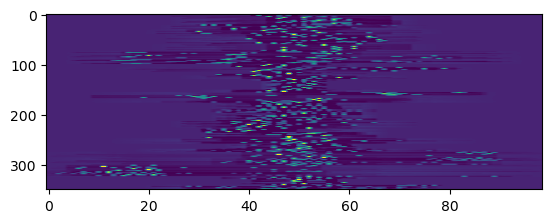

In [927]:
data_matrix = firing_corr_frag[0.004].T
aspect = 0.1
plt.imshow(data_matrix[frag_ind,:],aspect = aspect,vmax = vmax,
          vmin = vmin)

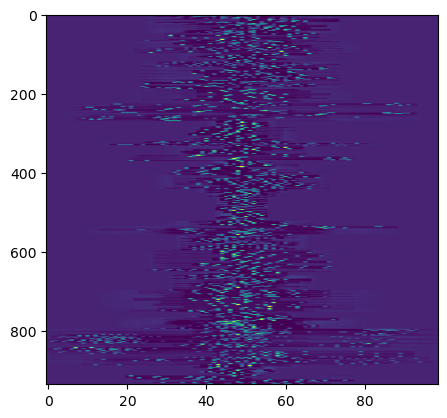

In [928]:
data_matrix = firing_corr_frag[0.004].T
aspect = 0.1
plt.imshow(data_matrix[cont_ind,:],aspect = aspect,vmax = vmax,
          vmin = vmin)

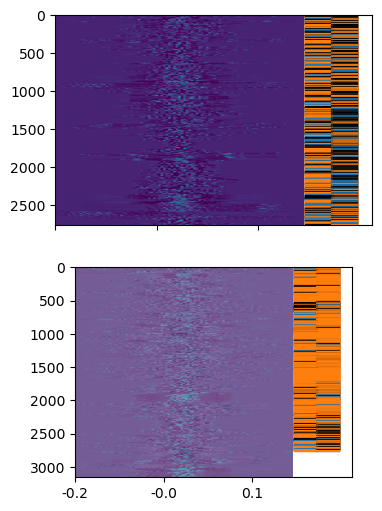

In [912]:
"""order with pairs"""
fig, axes = plt.subplots(2, 1, figsize = (12,6),sharex = True)
aspect = 0.03

data_matrix = firing_corr_cont[0.004].T
vmax = np.nanquantile(data_matrix,0.99)
vmin = np.nanquantile(data_matrix,0.1)

data_matrix = firing_corr_frag[0.004].T

center_ind = int(np.argwhere(lag_frag == 0).ravel())

frag_ind = np.argwhere(np.sum(color_frag == ['C0', 'C0'],axis = 1) == 2)
cont_ind = np.argwhere(np.sum(color_frag == ['C1', 'C1'],axis = 1) == 2)
order_partial = np.concatenate((frag_ind,cont_ind)).ravel()
row_order = np.concatenate((order_partial,np.setdiff1d(np.arange(len(color_frag)),order_partial)))

row_num = data_matrix.shape[0]
axes[0].imshow(data_matrix[row_order,:],aspect = aspect,vmax = vmax,
          vmin = vmin,extent = [lag_frag[0],lag_frag[-1],row_num,0])

for r in row_order:
    axes[0].plot([50,60],[r,r],color = color_frag[r,0])
    axes[0].plot([60,70],[r,r],color = color_frag[r,1])



data_matrix = firing_corr_cont[0.004].T
row_num = data_matrix.shape[0]
center_ind = int(np.argwhere(lag_cont == 0).ravel())

frag_ind = np.argwhere(np.sum(color_cont == ['C0', 'C0'],axis = 1) == 2)
cont_ind = np.argwhere(np.sum(color_cont == ['C1', 'C1'],axis = 1) == 2)
order_partial = np.concatenate((frag_ind,cont_ind)).ravel()
row_order = np.concatenate((order_partial,np.setdiff1d(np.arange(len(color_frag)),order_partial)))

axes[1].imshow(data_matrix[row_order,:],aspect = aspect,vmax = vmax,
          vmin = vmin,extent = [lag_cont[0],lag_cont[-1],row_num,0])

"""overlay"""
data_matrix = firing_corr_frag[0.004].T
center_ind = int(np.argwhere(lag_frag == 0).ravel())

frag_ind = np.argwhere(np.sum(color_frag == ['C0', 'C0'],axis = 1) == 2)
cont_ind = np.argwhere(np.sum(color_frag == ['C1', 'C1'],axis = 1) == 2)
order_partial = np.concatenate((frag_ind,cont_ind)).ravel()
row_order = np.concatenate((order_partial,np.setdiff1d(np.arange(len(color_frag)),order_partial)))

#row_num = data_matrix.shape[0]
axes[1].imshow(data_matrix[row_order,:],aspect = aspect,vmax = vmax,alpha =0.3,
          vmin = vmin,extent = [lag_frag[0],lag_frag[-1],row_num,0],cmap = 'bone_r')

for r in row_order:
    axes[1].plot([50,60],[r,r],color = color_cont[r,0])
    axes[1].plot([60,70],[r,r],color = color_cont[r,1])

axes[1].set_xticks(lag_cont[::40]);
axes[1].set_xticklabels(np.round(lag_cont[::40]*DELTA_T,1));

Text(-0.3, 0.4511300121507279, 'correlation of spiking among cells, binwidth and 1/2 overlapping binwidth')

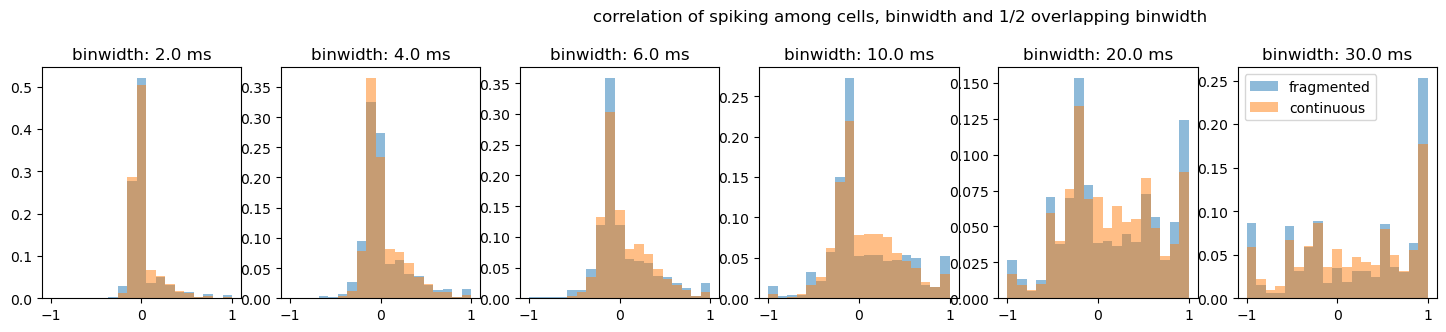

In [192]:
fig, axes = plt.subplots(1, len(DELTA_Ts), figsize = (3*len(DELTA_Ts),3))
axes_ind = 0

for DELTA_T in DELTA_Ts:
    data1 = firing_corr_frag[DELTA_T]
    axes[axes_ind].hist(data1,bins = np.linspace(-1,1,20),alpha = 0.5,
            weights = np.ones(len(data1))/len(data1),label = 'fragmented')
    
    data2 = firing_corr_cont[DELTA_T]
    axes[axes_ind].hist(data2,bins = np.linspace(-1,1,20),alpha = 0.5,
            weights = np.ones(len(data2))/len(data2),label = 'continuous')
    axes[axes_ind].set_title("binwidth: "+str(DELTA_T*1000)+" ms",fontsize = 12)
    axes_ind += 1
axes[axes_ind-1].legend()
axes[2].text(-0.3,axes[2].get_ylim()[1]*1.2,'correlation of spiking among cells, binwidth and 1/2 overlapping binwidth',fontsize = 12)